In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score
from typing import Any, Union, Callable

In [54]:
df = pd.read_csv('../data/dataset.csv')

In [55]:
df.head()

,usersha1,age,education,gender,name,country,music,artist_name,featured_artists,genre,...,valence,tempo,time_signature,track_genre,release_date,explicit,duration,music_id,id_artists,followers
0,83811,16,Undergraduate,Male,Danielle,Urban,Bank Account,21 Savage,"Birdy, Zoé",Dark Trap,...,0.198838,147.482666,5,Unknown,2017-09-23,True,3.67,2fQrGHiQOvpL9UgPvtYy6G,spotify:artist:1URnnhqYAYcrqrcwql10ft,440898
1,83811,16,Undergraduate,Male,Danielle,Urban,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,The Notorious B.I.G.,LUDMILLA,Underground Rap,...,0.904000,104.536000,4,hardcore,1997-03-04,False,4.29,4INDiWSKvqSKDEu7mh8HFz,spotify:artist:5me0Irg2ANcsgc93uaYrpb,849749
2,83811,16,Undergraduate,Male,Danielle,Urban,Little Talks,Of Monsters and Men,"Ninho, Snoop Dogg, Russ, Paramore",NaN,...,0.417000,102.961000,4,folk,2012-01-01,True,4.44,2ihCaVdNZmnHZWt0fvAM7B,spotify:artist:4dwdTW1Lfiq0cM8nBAqIIz,733052
3,13397,17,Middle School,Female,Angel,Non-Urban,Wherever I Go,OneRepublic,"Keith Urban, DJ Khaled, NIKI, MF DOOM",NaN,...,0.349000,99.961000,4,piano,2016-12-02,True,2.83,46jLy47W8rkf8rEX04gMKB,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ,766179
4,13397,17,Middle School,Female,Angel,Non-Urban,Hands To Myself,Selena Gomez,"SAINt JHN, David Bisbal, will.i.am",NaN,...,0.079792,84.918633,3,Unknown,2015-10-09,True,3.34,3CJvmtWw2bJsudbAC5uCQk,spotify:artist:0C8ZW7ezQVs4URX5aX7Kqx,399591


In [56]:
print(df.shape) # prints the dimensions of the DataFrame

missing_values = np.where(df.isnull(), 1, 0).sum()
print("\nMissing Values:\n", missing_values)

(35001, 32)

Missing Values:
 23616


In [57]:
# Remove rows containing missing values
df_clean = df.dropna()

# prints the dimensions of the cleaned DataFrame
df_clean.shape


(14025, 32)

In [60]:
df = pd.read_csv('../data/cleaned_data.csv')

In [61]:
duplicate_records = df.duplicated().sum()
print(duplicate_records)


0


In [62]:
df.shape

(14025, 33)

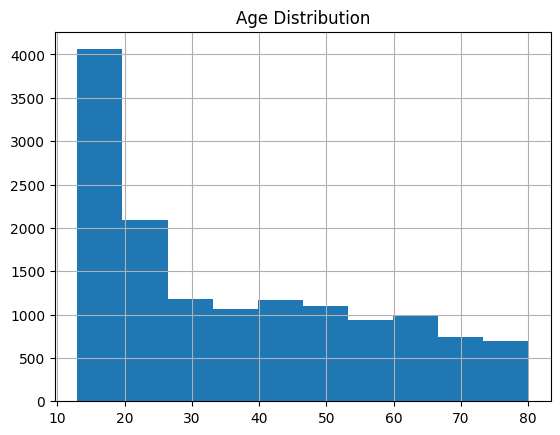

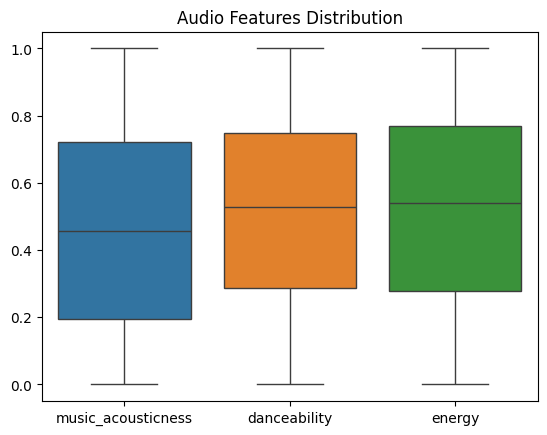

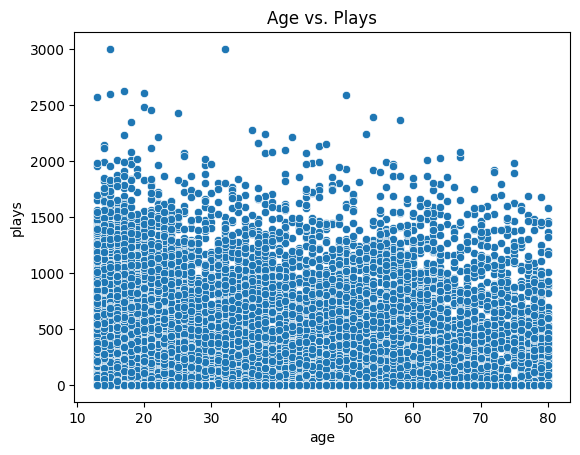

In [64]:
# Summary statistics
summary_stats = df.describe()

# Histograms
df['age'].hist()
plt.title('Age Distribution')
plt.show()

# Box plots for audio features
sns.boxplot(data=df[['music_acousticness', 'danceability', 'energy']])
plt.title('Audio Features Distribution')
plt.show()

# Scatter plots for correlations
sns.scatterplot(x='age', y='plays', data=df)
plt.title('Age vs. Plays')
plt.show()


In [65]:
# AGE GROUPING
# Example: Age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 25, 40, 60, 100], labels=['Teen', 'Young Adult', 'Adult', 'Senior', 'Elderly'])

df['age_group'].unique()

['Teen', 'Senior', 'Adult', 'Elderly', 'Young Adult']
Categories (5, object): ['Teen' < 'Young Adult' < 'Adult' < 'Senior' < 'Elderly']

Average Plays per User

In [66]:
df['avg_plays_per_user'] = df.groupby('usersha1')['plays'].transform('mean')
# df['avg_plays_per_user'].unique()

Aggregrate Popularity Metrics by User Demographics

In [67]:
df['avg_artiste_popularity'] = df.groupby(['age_group', 'gender'])['artiste_popularity'].transform('mean')
df['avg_audio_popularity'] = df.groupby(['age_group', 'gender'])['audio_popularity'].transform('mean')


Summary Statistics for Audio Features by User

In [68]:
audio_features = ['music_acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo']
for feature in audio_features:
    df[f'avg_{feature}_by_demo'] = df.groupby(['age_group', 'gender'])[feature].transform('mean')


Temporal Features:
Extracting Year, Month and Day from Release Date

In [69]:
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
df['release_month'] = pd.to_datetime(df['release_date']).dt.month
df['release_day'] = pd.to_datetime(df['release_date']).dt.day


Calculate Song's Age Since Release:

In [70]:
current_year = pd.to_datetime('today').year
df['song_age'] = current_year - df['release_year']


User Preferences:

In [71]:
user_profiles = df.groupby('usersha1')['genre'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
df['user_favorite_genre'] = df['usersha1'].map(user_profiles)


Calculate Diversity of Genres Each User Listens To:

In [72]:
df['user_genre_diversity'] = df.groupby('usersha1')['genre'].transform(lambda x: x.nunique())

Interaction Features:
Capture Interactions Between User Demographics and Song Characteristics:

In [73]:
df['age_genre_interaction'] = df['age'] * df['genre'].apply(lambda x: hash(x) % 100)


Create Features that Measure User Affinity Towards Certain Genres or Artists:

In [74]:
user_genre_affinity = df.groupby(['usersha1', 'genre'])['plays'].sum().unstack().fillna(0)
df['user_genre_affinity'] = df.apply(lambda row: user_genre_affinity.loc[row['usersha1'], row['genre']], axis=1)


Advanced Audio Features:
Create Composite Features from Existing Audio Features:

In [75]:
df['energy_acousticness_ratio'] = df['energy'] / (df['music_acousticness'] + 1e-9)


Verification  checks

In [89]:
# Checking the average plays per user calculation
avg_plays_per_user_check = df.groupby('usersha1')['plays'].mean()
assert df['avg_plays_per_user'].equals(df['usersha1'].map(avg_plays_per_user_check))

# Checking the average artiste popularity by demographics
avg_artiste_popularity_check = df.groupby(['age_group', 'gender'])['artiste_popularity'].mean()
assert df['avg_artiste_popularity'].equals(df[['age_group', 'gender']].apply(lambda row: avg_artiste_popularity_check[row['age_group'], row['gender']], axis=1))

# Checking the average audio popularity by demographics
avg_audio_popularity_check = df.groupby(['age_group', 'gender'])['audio_popularity'].mean()
assert df['avg_audio_popularity'].equals(df[['age_group', 'gender']].apply(lambda row: avg_audio_popularity_check[row['age_group'], row['gender']], axis=1))


In [90]:
for feature in audio_features:
    avg_feature_by_demo_check = df.groupby(['age_group', 'gender'])[feature].mean()
    assert df[f'avg_{feature}_by_demo'].equals(df[['age_group', 'gender']].apply(lambda row: avg_feature_by_demo_check[row['age_group'], row['gender']], axis=1))


In [91]:
df['release_year_check'] = pd.to_datetime(df['release_date']).dt.year
df['release_month_check'] = pd.to_datetime(df['release_date']).dt.month
df['release_day_check'] = pd.to_datetime(df['release_date']).dt.day

assert df['release_year'].equals(df['release_year_check'])
assert df['release_month'].equals(df['release_month_check'])
assert df['release_day'].equals(df['release_day_check'])


In [92]:
df['release_year_check'] = pd.to_datetime(df['release_date']).dt.year
df['release_month_check'] = pd.to_datetime(df['release_date']).dt.month
df['release_day_check'] = pd.to_datetime(df['release_date']).dt.day

assert df['release_year'].equals(df['release_year_check'])
assert df['release_month'].equals(df['release_month_check'])
assert df['release_day'].equals(df['release_day_check'])


In [93]:
df['song_age_check'] = current_year - df['release_year']
assert df['song_age'].equals(df['song_age_check'])


In [94]:
# Adding a feature for season based on release month
df['release_season'] = df['release_month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')


In [95]:
user_profiles_check = df.groupby('usersha1')['genre'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
assert df['user_favorite_genre'].equals(df['usersha1'].map(user_profiles_check))


In [96]:
user_genre_diversity_check = df.groupby('usersha1')['genre'].nunique()
assert df['user_genre_diversity'].equals(df['usersha1'].map(user_genre_diversity_check))


In [97]:
# Checking the interaction term
df['age_genre_interaction_check'] = df['age'] * df['genre'].apply(lambda x: hash(x) % 100)
assert df['age_genre_interaction'].equals(df['age_genre_interaction_check'])


In [98]:
# Checking user genre affinity
df['user_genre_affinity_check'] = df.apply(lambda row: user_genre_affinity.loc[row['usersha1'], row['genre']], axis=1)
assert df['user_genre_affinity'].equals(df['user_genre_affinity_check'])


In [99]:
# Checking the energy_acousticness_ratio calculation
df['energy_acousticness_ratio_check'] = df['energy'] / (df['music_acousticness'] + 1e-9)
assert df['energy_acousticness_ratio'].equals(df['energy_acousticness_ratio_check'])


**Feature Selection**

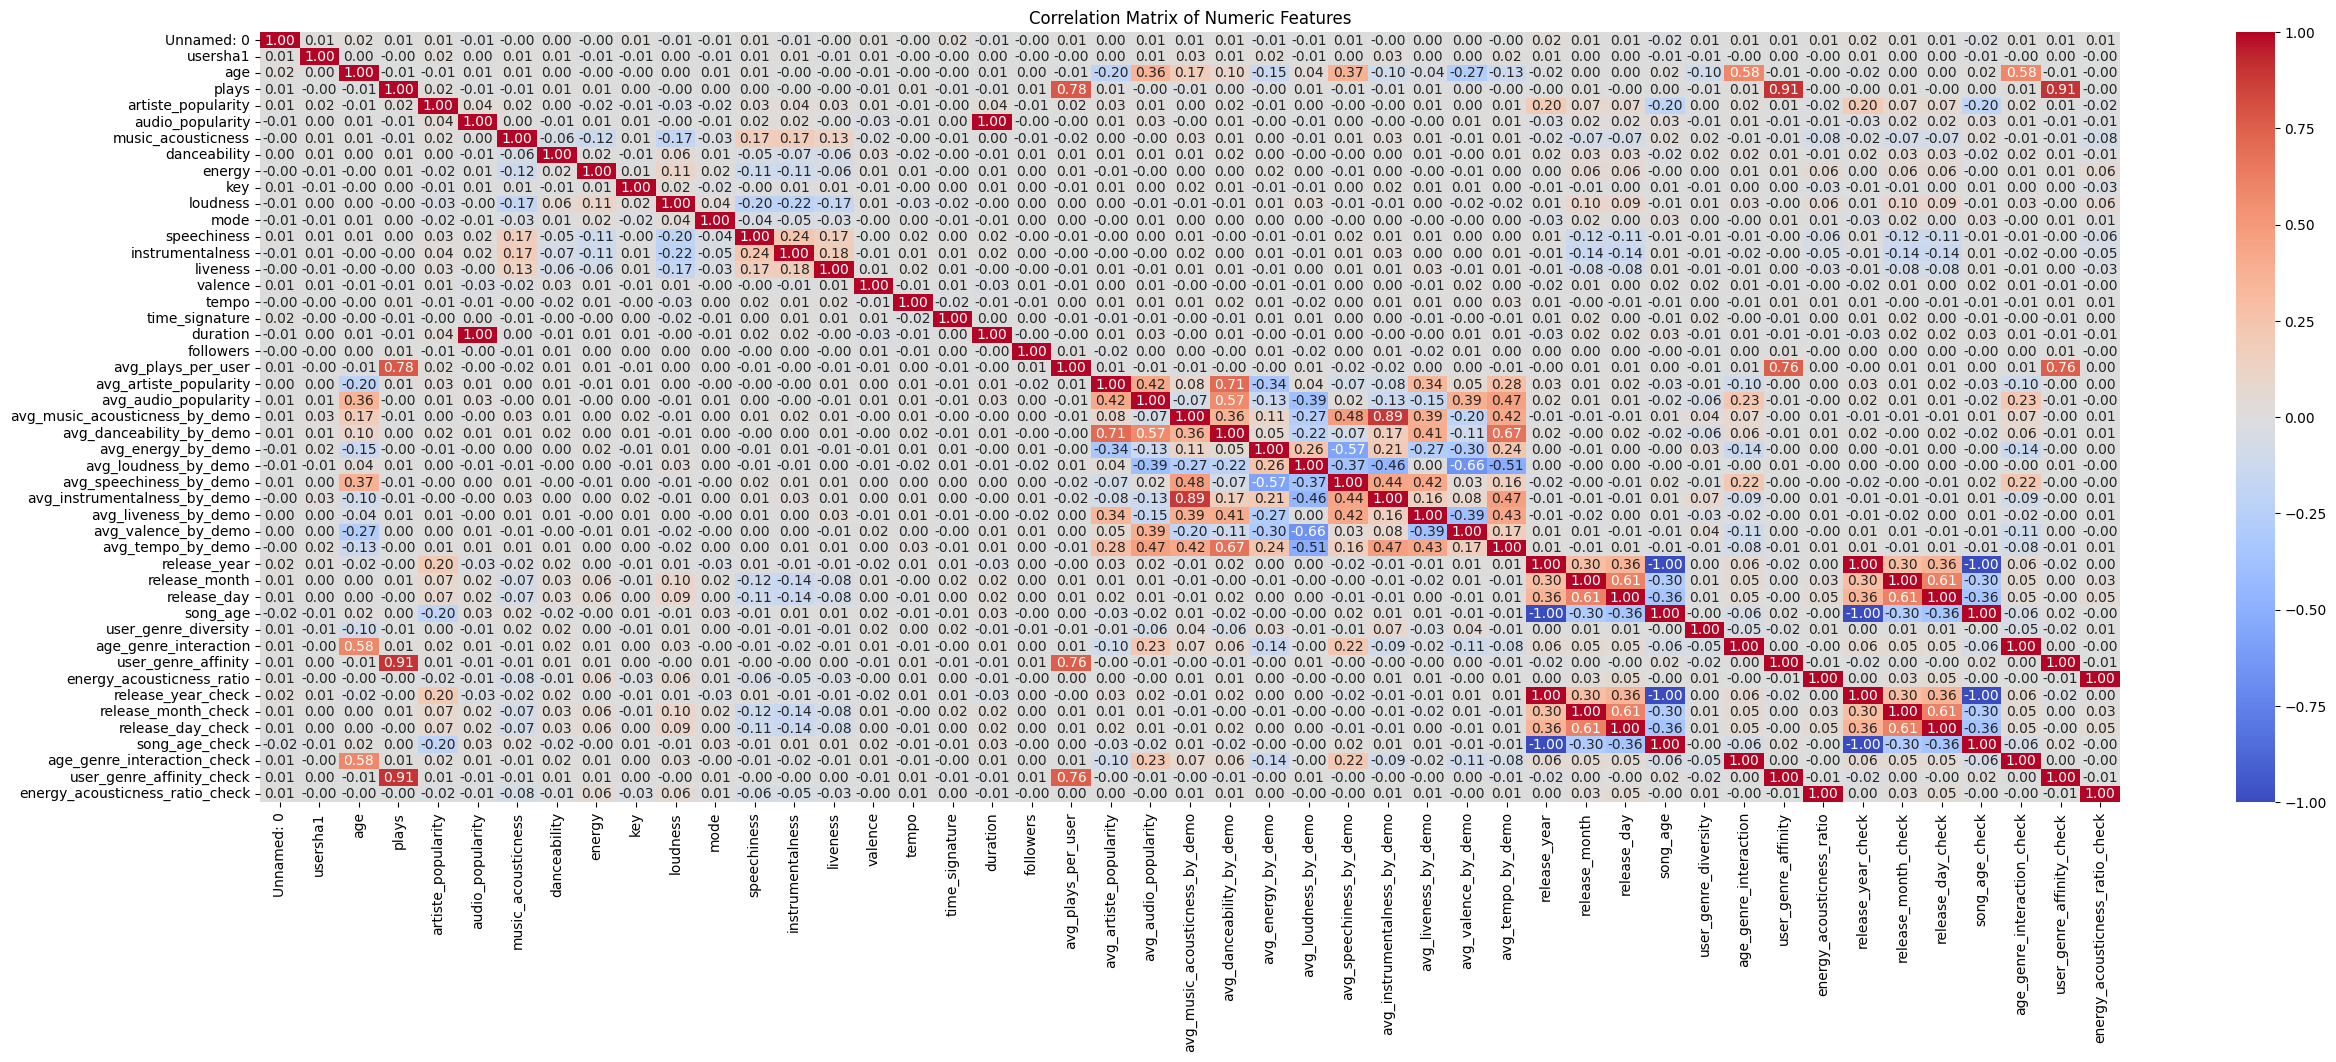

In [100]:
# Assuming df is already loaded and preprocessed
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [101]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'usersha1'], inplace=True)

# Identify features
categorical_features = ['education', 'gender', 'country', 'age_group', 'user_favorite_genre', 'release_season']
numerical_features = df.select_dtypes(include=[float, int]).columns.tolist()

# Remove the target variable from numerical features
numerical_features.remove('plays')  # Assuming 'plays' is the target variable

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the target variable
X = df.drop(columns=['plays'])
y = df['plays']

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Checking the shape of the preprocessed data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (11220, 96)
Shape of X_test: (2805, 96)
Shape of y_train: (11220,)
Shape of y_test: (2805,)


Top 10 Important features
Feature ranking:
43. feature 42 (0.47763291312763423)
36. feature 35 (0.3709579970752279)
18. feature 17 (0.0468391167411036)
34. feature 33 (0.021142987464528192)
13. feature 12 (0.005199510088805882)
12. feature 11 (0.0047516875830876755)
10. feature 9 (0.0043882677986738184)
6. feature 5 (0.004294363449770748)
11. feature 10 (0.004197729954525289)
17. feature 16 (0.004108180862523328)
Selected Features:
Int64Index([42, 35, 17, 33, 12, 11, 9, 5, 10, 16], dtype='int64')


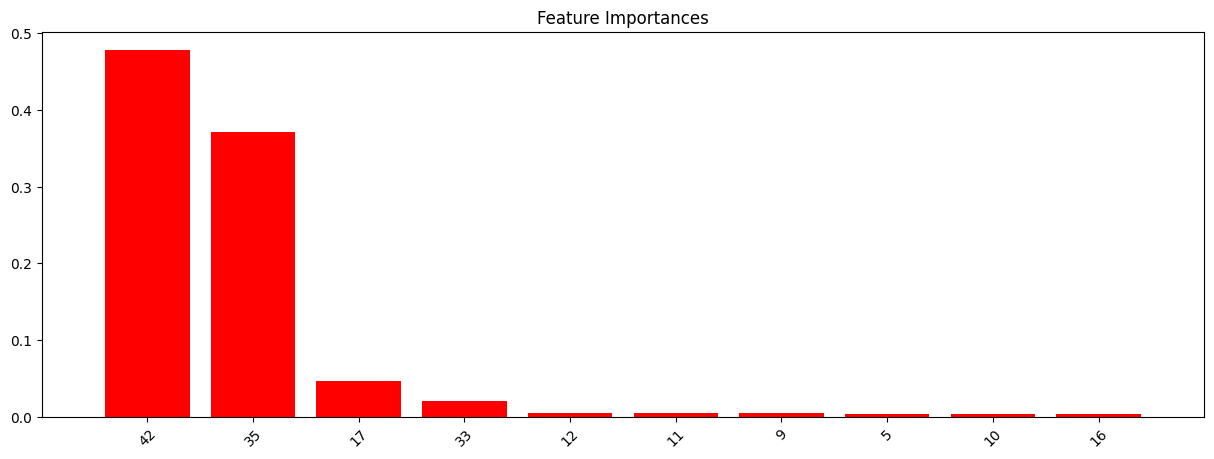

In [102]:
# Keep a copy of the DataFrame for later use
X_train_df = pd.DataFrame(X_train)  # Convert numpy array back to DataFrame if needed

# Fit a RandomForestRegressor to analyze feature importance
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get the top 10 features
print('Top 10 Important features')
top_10_features = indices[:10]

# Print the feature ranking
print("Feature ranking:")
for f in top_10_features:
    print(f"{f + 1}. feature {X_train_df.columns[f]} ({importances[f]})")

# Use the original DataFrame to get the feature names
selected_features = X_train_df.columns[top_10_features]
print("Selected Features:")
print(selected_features)

# Plot the feature importances
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(10), importances[top_10_features], color="r", align="center")
# Use feature names as x-ticks
plt.xticks(range(10), selected_features, rotation=45)
plt.xlim([-1, 10])
plt.show()


In [103]:
# get me the printed array of items indexed by these from the dataframe 

# Assuming 'df' is your DataFrame
indices = [35, 42, 17, 33, 12, 9, 11, 10, 16, 13]
selected_columns = df.columns[indices]

# Print the names of the selected columns
print(selected_columns)


Index(['avg_music_acousticness_by_demo', 'avg_valence_by_demo', 'mode',
       'avg_artiste_popularity', 'music_acousticness', 'plays',
       'audio_popularity', 'artiste_popularity', 'loudness', 'danceability'],
      dtype='object')


In [104]:
df.shape

(14025, 61)